In [1]:
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
from omegaconf import OmegaConf
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
import torch
import pandas as pd

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [67]:
class Args:
    def __init__(self, dictionary):
        self.__dict__ = dictionary

    def __getattr__(self, key):
        if key in self.__dict__:
            return self.__dict__[key]
        else:
            raise AttributeError(f"'DictToObject' object has no attribute '{key}'")

    def __call__(self, key):
        return self.__getattr__(key)

def t2np(t):
    return ((t.permute(0,2, 3, 1) + 1) / 2).clamp(0,1).cpu().numpy()

transf_images = {}
real_images = {}

def encode(solver, dataloader, train_dataloader, pert_list):
    transf_images = {}
    real_images = {}
    with torch.no_grad():
        for batch in train_dataloader:
            X_ctr = batch["X"][0]
            for pert in tqdm(pert_list):
                z = torch.randn(X_ctr.shape[0], 100, args.z_dimension).mean(1).cuda()
                try:
                    id_pert = dataloader.mol2id[pert]*torch.ones(X_ctr.shape[0]).long().cuda()
                except:
                    continue
                y = solver.embedding_matrix(id_pert)
                y = torch.cat([y, z], dim=1)
                y = solver.nets.mapping_network(y)
                _, X_generated = solver.nets.generator(X_ctr, y)
                transf_images[pert] = t2np(X_generated.detach().cpu())
                real_images[pert] = t2np(X_ctr.detach().cpu())
            break
    return transf_images, real_images

In [68]:
config_dict = {
    "task_name": "cpg0000_total_large_transported",
    "img_size": 96,
    "latent_dim": 100,
    "hidden_dim": 512,
    "style_dim": 32,
    "stochastic": True,
    "z_dimension": 20,
    "add_controls": False,
    "dim_in": 64,
    "lambda_reg": 1,
    "lambda_cyc": 1,
    "lambda_sty": 1,
    "lambda_ds": 1,
    "total_epochs": 100,
    "ds_iter": 200000,
    "resume_iter": 0,
    "batch_size": 32,
    "val_batch_size": 20,
    "lr": 0.0001,
    "f_lr": 0.0001,
    "beta1": 0,
    "beta2": 0.99,
    "weight_decay": 0.0001,
    "num_outs_per_domain": 10,
    "single_style": True,
    "ood_set": None,
    "mol_list": None,
    "balanced": False,
    "trainable_emb": True,
    "dataset_name": "cpg0000",
    "n_channels": 5,
    "num_workers": 6,
    "seed": 42,
    "image_path": "/lustre/groups/ml01/datasets/projects/cpg0000_alessandro/cpg0000_u2os_normalized_segmented_large_transported",
    "data_index_path": "/lustre/groups/ml01/datasets/projects/cpg0000_alessandro/metadata/metadata_large_full.csv",
    "embedding_path": None,
    "experiment_directory": "../project_folder/experiments/",
    "sample_dir": "sample",
    "checkpoint_dir": "checkpoint",
    "basal_vs_real_folder": "basal_vs_real",
    "naming_key": "dataset_name",
    "embedding_folder": "embeddings",
    "resume_dir": '',
    "augment_train": True,
    "normalize": True,
    "print_every": 10,
    "sample_every": 1000,
    "save_every": 500,
    "eval_every": 500,
    "encode_rdkit": True,
    "num_layers_mapping_net": 1,
    "filename": "epoch_{epoch:04d}",
    "monitor": "fid_transformations",
    "mode": "min",
    "save_last": True,
    "offline": False,
    "project": "cpg0000_total_large_transported",
    "log_model": True,
    "accelerator": "gpu",
    "log_every_n_steps": 10
}

args = OmegaConf.create(config_dict)

dest_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240115_35929b66-de4e-4acf-a58f-d95b26034998_cpg0000_total_large_transported"

In [69]:
dataloader = CellDataLoader(args)

In [70]:
solver = IMPAmodule(args, dest_dir, dataloader)
solver._load_checkpoint(76)

Number of parameters in generator: 24102789
Number of parameters in style_encoder: 14314208
Number of parameters in discriminator: 14534798
Number of parameters in mapping_network: 3872
Initializing embedding_matrix...
Initializing generator...
Initializing style_encoder...
Initializing discriminator...
Initializing mapping_network...
IMPAmodule(
  (embedding_matrix): Embedding(462, 100)
  (generator): DataParallel(
    (module): Generator(
      (from_rgb): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (encode): ModuleList(
        (0): ResBlk(
          (actv): LeakyReLU(negative_slope=0.2)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False

In [71]:
train_dataloader = dataloader.train_dataloader()
val_dataloader = dataloader.val_dataloader()

## High effect

In [30]:
pert_to_inspect_high_effect = [ "1-octanol", "7-hydroxystaurosporine", "AVL-292", "AZD7762", "BI-2536", "BMS-536924", 
                      "BVT-948", "GK921", "GSK1070916", "GSK2110183", "ITGB2", "KG-5", "NSC-663284", 
                      "NSC-95397", "PP-121", "RGB-286638", "SU3327", "TG-02", "TG-101348", "UNC1999", 
                      "UNC2025", "anisomycin", "azeliragon", "briciclib", "colchicine", "delanzomib", 
                      "dexamethasone", "homoharringtonine", "ibutamoren", "ixabepilone", "oxibendazole",
                      "ponatinib", "puromycin", "pyrrolidine-dithiocarbamate", "romidepsin", "ryuvidine"
                  ]

In [31]:
transf_images = {}
real_images = {}

# z_common = torch.randn(1, 100, args.z_dimension).mean(1).cuda()
with torch.no_grad():
    for batch in train_dataloader:
        X_ctr = batch["X"][0]
        for pert in tqdm(pert_to_inspect_high_effect):
            # z = z_common.repeat(X_ctr.shape[0], 1)
            z = torch.randn(X_ctr.shape[0], args.z_dimension).cuda()
            id_pert = dataloader.mol2id[pert]*torch.ones(X_ctr.shape[0]).long().cuda()
            y = solver.embedding_matrix(id_pert)
            y = torch.cat([y, z], dim=1)
            y = solver.nets.mapping_network(y)
            _, X_generated = solver.nets.generator(X_ctr, y)
            transf_images[pert] = t2np(X_generated.detach().cpu())
            real_images[pert] = t2np(X_ctr.detach().cpu())
        break

100%|██████████| 36/36 [00:01<00:00, 19.93it/s]


In [ ]:
#### for pert in transf_images:
    print(pert)
    for i in range(len(batch)):
        print("real")
        plt.figure(figsize=(1,1))
        plt.imshow(real_images[pert][i][:,:,[0,3,4]])
        plt.show()
        print("transf")
        plt.figure(figsize=(1,1))
        plt.imshow(transf_images[pert][i][:,:,[0,3,4]])
        plt.show()        

## Low effect - ORF

In [72]:
data_index = pd.read_csv("/lustre/groups/ml01/datasets/projects/cpg0000_alessandro/metadata/metadata_large_full.csv", index_col=0)

In [73]:
data_index_orf = data_index.loc[data_index.PERT_TYPE=="ORF"]

In [74]:
orf_inactive = data_index_orf.CPD_NAME[:20]

In [75]:
transf_images, real_images = encode(solver, dataloader, train_dataloader, orf_inactive)

100%|██████████| 20/20 [00:00<00:00, 22.47it/s]


PDE3A
real


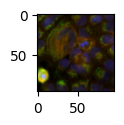

transf


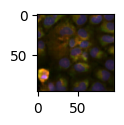

real


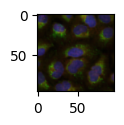

transf


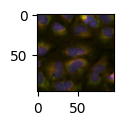

real


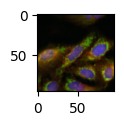

transf


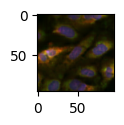

real


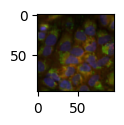

transf


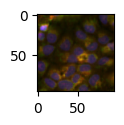

PLK1
real


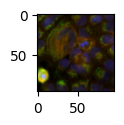

transf


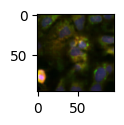

real


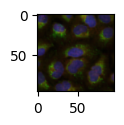

transf


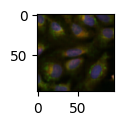

real


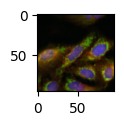

transf


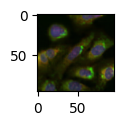

real


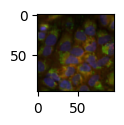

transf


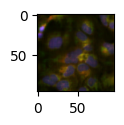

JAK1
real


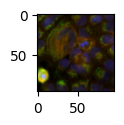

transf


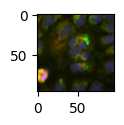

real


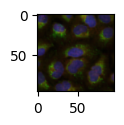

transf


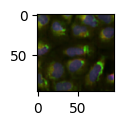

real


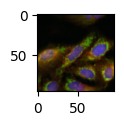

transf


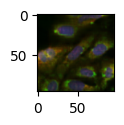

real


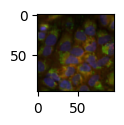

transf


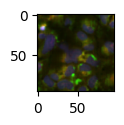

EZH2
real


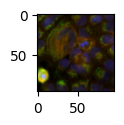

transf


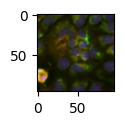

real


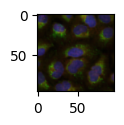

transf


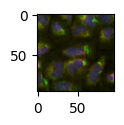

real


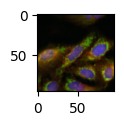

transf


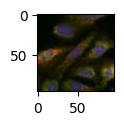

real


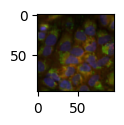

transf


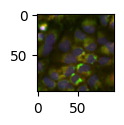

NAMPT
real


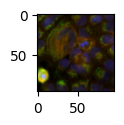

transf


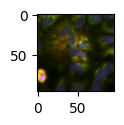

real


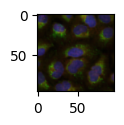

transf


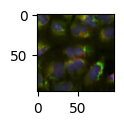

real


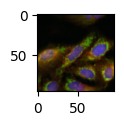

transf


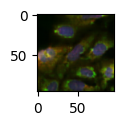

real


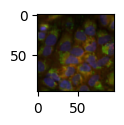

transf


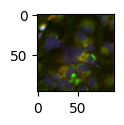

ICAM1
real


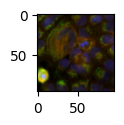

transf


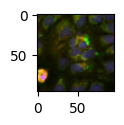

real


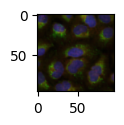

transf


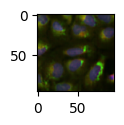

real


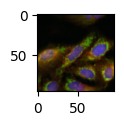

transf


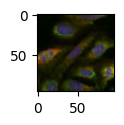

real


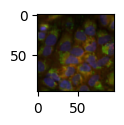

transf


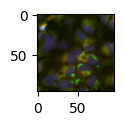

KCNK1
real


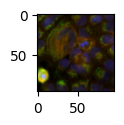

transf


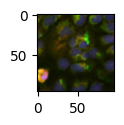

real


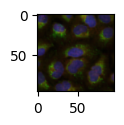

transf


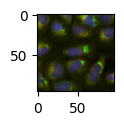

real


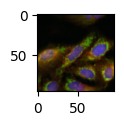

transf


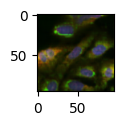

real


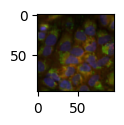

transf


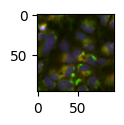

PPARD
real


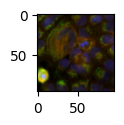

transf


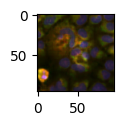

real


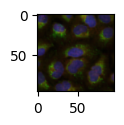

transf


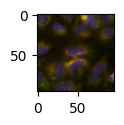

real


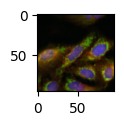

transf


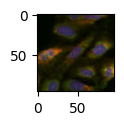

real


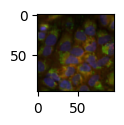

transf


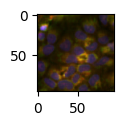

KCNQ2
real


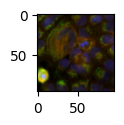

transf


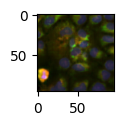

real


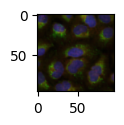

transf


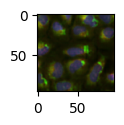

real


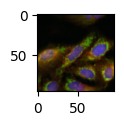

transf


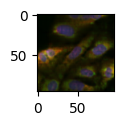

real


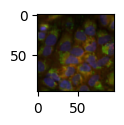

transf


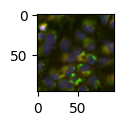

FPR1
real


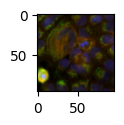

transf


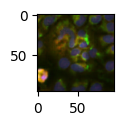

real


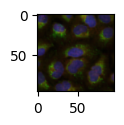

transf


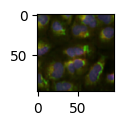

real


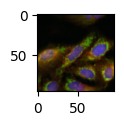

transf


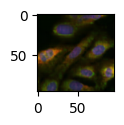

real


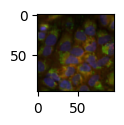

transf


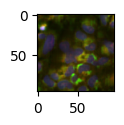

FFAR4
real


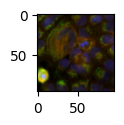

transf


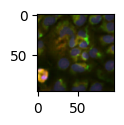

real


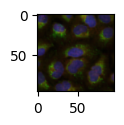

transf


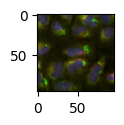

real


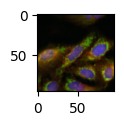

transf


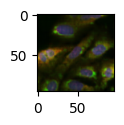

real


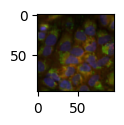

transf


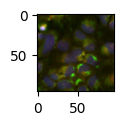

HRH4
real


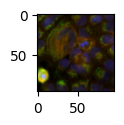

transf


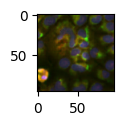

real


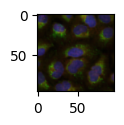

transf


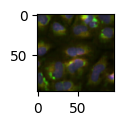

real


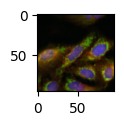

transf


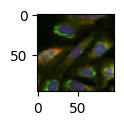

real


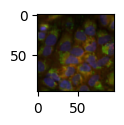

transf


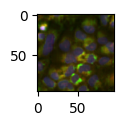

PTPN2
real


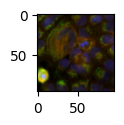

transf


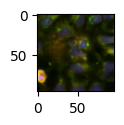

real


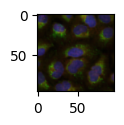

transf


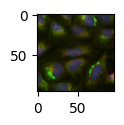

real


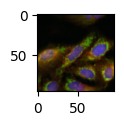

transf


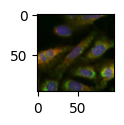

real


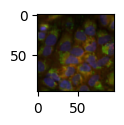

transf


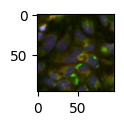

ATP5F1D
real


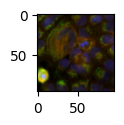

transf


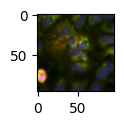

real


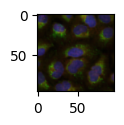

transf


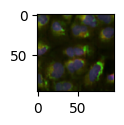

real


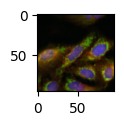

transf


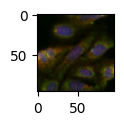

real


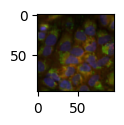

transf


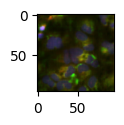

MET
real


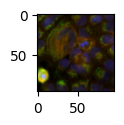

transf


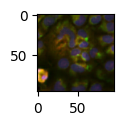

real


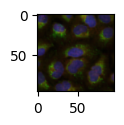

transf


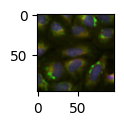

real


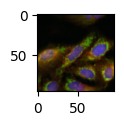

transf


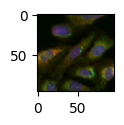

real


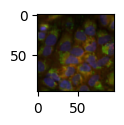

transf


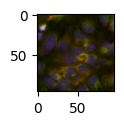

PLA2G1B
real


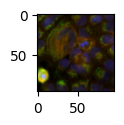

transf


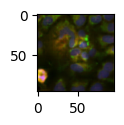

real


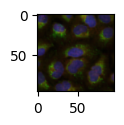

transf


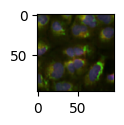

real


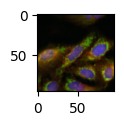

transf


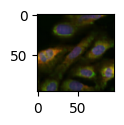

real


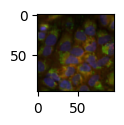

transf


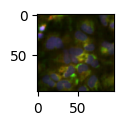

RNASE1
real


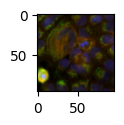

transf


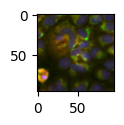

real


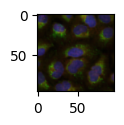

transf


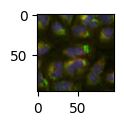

real


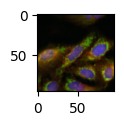

transf


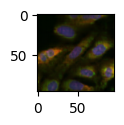

real


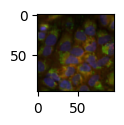

transf


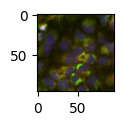

In [76]:
for pert in transf_images:
    print(pert)
    for i in range(len(batch)):
        print("real")
        plt.figure(figsize=(1,1))
        plt.imshow(real_images[pert][i][:,:,[0,3,4]])
        plt.show()
        print("transf")
        plt.figure(figsize=(1,1))
        plt.imshow(transf_images[pert][i][:,:,[0,3,4]])
        plt.show()       

In [77]:
dataloader.mol2id

{'1-EBIO': 0,
 '1-octanol': 1,
 '2,5-furandimethanol': 2,
 '2-Oleoylglycerol': 3,
 '4-CMTB': 4,
 '4-methylhistamine': 5,
 '7-hydroxystaurosporine': 6,
 'A-987306': 7,
 'A205804': 8,
 'ABL1': 9,
 'AC-710': 10,
 'ADA': 11,
 'ADH1C': 12,
 'ADORA2A': 13,
 'ADRA2B': 14,
 'AGER': 15,
 'AK-7': 16,
 'AKR1B1': 17,
 'AKR1C1': 18,
 'AKT1': 19,
 'ALDH2': 20,
 'ALK': 21,
 'AMG900': 22,
 'ANR-94': 23,
 'ANXA1': 24,
 'AR-12': 25,
 'ASIC1': 26,
 'ATM': 27,
 'ATP5F1D': 28,
 'AURKB': 29,
 'AVL-292': 30,
 'AVPR1A': 31,
 'AZ191': 32,
 'AZD1283': 33,
 'AZD7762': 34,
 'AZD9668': 35,
 'BAM7': 36,
 'BAN-ORL-24': 37,
 'BAX': 38,
 'BAX-channel-blocker': 39,
 'BAY-87-2243': 40,
 'BI-2536': 41,
 'BMS-536924': 42,
 'BMS-587101': 43,
 'BQ-788': 44,
 'BRAF': 45,
 'BRD4': 46,
 'BRL-50481': 47,
 'BTK': 48,
 'BVT-948': 49,
 'CA14': 50,
 'CA5A': 51,
 'CACNA2D3': 52,
 'CACNB4': 53,
 'CACNG1': 54,
 'CASP3': 55,
 'CATSPER4': 56,
 'CC-401': 57,
 'CCG-50014': 58,
 'CCG-63802': 59,
 'CCND1': 60,
 'CCR1': 61,
 'CDC25A': 62,
 '